In [1]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Multitap is a net that, given a known preamble, will take in the convolved preamble and estimate the CFO.
'''

class CFO_Multitap():
    def __init__(self, preamble_length = 40, batch_size = 1500, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.omega_original = tf.placeholder(tf.float32, [None, 1])
        self.preamble_channel = tf.placeholder(tf.float32, [None, self.preamble_length,2])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True, name='cfo_layer_1')
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True, name='cfo_layer_2')
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True, name='cfo_layer_3')
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True, name='cfo_layer_4')

        self.est_omega = cfo_layer_4
        
        ###############
        # CFO Correction on the convolved data
        ###############

        preamble_cfo_complex = tf.complex(self.preamble_convolved[:,:,0], self.preamble_convolved[:,:,1])
        preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

        preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                                     tf.imag(preamble_rotated_complex[:,:])], axis=2)
        
        self.preamble_cfo_corrected = tf.squeeze(preamble_rotated,-1)
        
        self.mse_loss = tf.losses.mean_squared_error(self.preamble_channel, self.preamble_cfo_corrected)
    
    
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.omega_original, self.est_omega)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_omega, test_mse_loss = self.sess.run([self.surr,self.est_omega, self.mse_loss], 
                                                             feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        # save the weights from the layers
        with tf.variable_scope("cfo_layer_1", reuse=True):
            weights_1 = tf.get_variable("kernel").eval(session = self.sess)
            bias_1 = tf.get_variable("bias").eval(session = self.sess)
        with tf.variable_scope("cfo_layer_2", reuse=True):
            weights_2 = tf.get_variable("kernel").eval(session = self.sess)
            bias_2 = tf.get_variable("bias").eval(session = self.sess)
        with tf.variable_scope("cfo_layer_3", reuse=True):
            weights_3 = tf.get_variable("kernel").eval(session = self.sess)
            bias_3 = tf.get_variable("bias").eval(session = self.sess)
        with tf.variable_scope("cfo_layer_4", reuse=True):
            weights_4 = tf.get_variable("kernel").eval(session = self.sess)
            bias_4 = tf.get_variable("bias").eval(session = self.sess)
                    
        return (test_cost,test_omega, test_mse_loss, weights_1, bias_1, weights_2, bias_2, weights_3, bias_3,
                 weights_4, bias_4)
    
            
    def train_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return train_cost
    


/home/laura/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Multitap is a net that, given a known preamble, will take in the convolved preamble and estimate the CFO.
'''

class CFO_Multitap_Noise():
    def __init__(self, preamble_length = 40, batch_size = 1500, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.omega_original = tf.placeholder(tf.float32, [None, 1])
        self.preamble_channel = tf.placeholder(tf.float32, [None, self.preamble_length,2])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True)
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True)

        self.est_omega = cfo_layer_4
        
        ###############
        # CFO Correction on the convolved data
        ###############

        preamble_cfo_complex = tf.complex(self.preamble_convolved[:,:,0], self.preamble_convolved[:,:,1])
        preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

        preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                                     tf.imag(preamble_rotated_complex[:,:])], axis=2)
        
        self.preamble_cfo_corrected = tf.squeeze(preamble_rotated,-1)
        
        self.mse_loss = tf.losses.mean_squared_error(self.preamble_channel, self.preamble_cfo_corrected)
    
    
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.omega_original, self.est_omega)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_omega, test_mse_loss = self.sess.run([self.surr,self.est_omega, self.mse_loss], 
                                                             feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        
        
        return test_cost,test_omega, test_mse_loss
    
            
    def train_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return train_cost
    


In [3]:
def data_generation(epochs):
    
    import numpy as np
    import scipy.signal as sig
    from numpy import linalg as LA
    import matplotlib.pyplot as plt

    # Create training and test data for the NN
    batch_size = 1500

    snr=10

    # number of random preambles that will be trained and tested on
    num_train=epochs*batch_size
    num_test=batch_size

    preamble_length = 40
    channel_length = 2

    # QPSK
    preamble_train_orig = np.zeros((num_train,preamble_length,2))
    preamble_train_cfo = np.zeros((num_train,preamble_length,2))
    preamble_test_channel = np.zeros((num_test,preamble_length,2))
    preamble_test_orig = np.zeros((num_test,preamble_length,2))
    preamble_test_cfo = np.zeros((num_test,preamble_length,2))
    preamble_train_noisy = np.zeros((num_train,preamble_length,2))
    preamble_test_noisy = np.zeros((num_test,preamble_length,2))
    preamble_train_channel = np.zeros((num_train,preamble_length,2))


    # the max value the CFO rate can be 
    max_omega = 1/100
    # the cfo rate is in number of radians turned per sample
    omega_train = np.random.uniform(low=-max_omega,high=max_omega, size=((num_train,1)))
    omega_test = np.random.uniform(low=-max_omega,high=max_omega, size=((num_test,1)))
    
    # assume the channel length is the same for imaginary and real
    channel_train = np.zeros((num_train,channel_length,2))
    channel_test = np.zeros((num_test,channel_length,2))


    for i in range(num_train):
        # original preamble - known to both TX and RX
        preamble_train_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
        
        
        for k in range(2):
            channel_train[i,:,k]=np.random.uniform(0,1,channel_length)
#             channel_train[i,:,k]=([1,0])
            # normalize power to 1
            channel_train[i,:,k] = channel_train[i,:,k]/(np.linalg.norm(channel_train[i,:,k]))
            
            # apply the channel to the preamble
            preamble_train_channel[i,:,k] = sig.convolve(preamble_train_orig[i,:,k], 
                                                         channel_train[i,:,k], mode='same')
        
        
        # rotate data according to cfo
        preamble_cfo_complex = np.vectorize(complex)(preamble_train_channel[i,:,0], preamble_train_channel[i,:,1])
        preamble_cfo_complex = preamble_cfo_complex.reshape((preamble_length,1))
        # print(preamble_cfo_complex.shape)

        # build the rotation matrix
        incremented_omega = np.zeros((preamble_length,1))
        for j in range(preamble_length):
            incremented_omega[j]=omega_train[i]*j

        rotation_complex = np.exp(0.0+1j*incremented_omega)
        preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)

        preamble_train_cfo[i,:,:] = np.squeeze(np.stack([np.real(preamble_rotated_complex[:,:]), 
                                     np.imag(preamble_rotated_complex[:,:])], axis=1),axis=-1)
        
#         # rotate data according to cfo
#         for j in range(preamble_length):
#             preamble_train_cfo[i,j,0]=(preamble_train_channel[i,j,0]*np.cos(omega_train[i]*j)
#                                            -preamble_train_channel[i,j,1]*np.sin(omega_train[i]*j))
#             preamble_train_cfo[i,j,1]=(preamble_train_channel[i,j,0]*np.sin(omega_train[i]*j)
#                                           +preamble_train_channel[i,j,1]*np.cos(omega_train[i]*j))
            
        # add AWG noise to the preamble
        std = np.power(10.0, -snr/20)
    
        if snr > 0:
            preamble_train_noisy[i,:,:] = std * np.random.randn(preamble_length,2)+preamble_train_cfo[i,:,:]
        else:
            preamble_train_noisy[i,:,:] = preamble_train_cfo[i,:,:]

            
        if i % 100000 == 0:
            print(i)


    for i in range(0, num_test):
        # original preamble - known to both TX and RX
        preamble_test_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
       
        
        for k in range(2):
            channel_test[i,:,k]=np.random.uniform(0,1,channel_length)
#             channel_test[i,:,k]=([1,0])
            # normalize power to 1
            channel_test[i,:,k] = channel_test[i,:,k]/(np.linalg.norm(channel_test[i,:,k]))
            
            # apply the channel to the preamble
            preamble_test_channel[i,:,k] = sig.convolve(preamble_test_orig[i,:,k], 
                                                        channel_test[i,:,k], mode='same')
        
        # rotate data according to cfo
        preamble_cfo_complex = np.vectorize(complex)(preamble_test_channel[i,:,0], preamble_test_channel[i,:,1])
        preamble_cfo_complex = preamble_cfo_complex.reshape((preamble_length,1))
        # print(preamble_cfo_complex.shape)

        # build the rotation matrix
        incremented_omega = np.zeros((preamble_length,1))
        for j in range(preamble_length):
            incremented_omega[j]=omega_test[i]*j

        rotation_complex = np.exp(0.0+1j*incremented_omega)
        preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)

        preamble_test_cfo[i,:,:] = np.squeeze(np.stack([np.real(preamble_rotated_complex[:,:]), 
                                     np.imag(preamble_rotated_complex[:,:])], axis=1),axis=-1)
        
        
        
        
#         for j in range(preamble_length):
#             preamble_test_cfo[i,j,0]=(preamble_test_channel[i,j,0]*np.cos(omega_test[i]*j)
#                                            -preamble_test_channel[i,j,1]*np.sin(omega_test[i]*j))
#             preamble_test_cfo[i,j,1]=(preamble_test_channel[i,j,0]*np.sin(omega_test[i]*j)
#                                           +preamble_test_channel[i,j,1]*np.cos(omega_test[i]*j))
            
        # add AWG noise to the preamble
        std = np.power(10.0, -snr/20)
    
        if snr > 0:
            preamble_test_noisy[i,:,:] = std * np.random.randn(preamble_length,2)+preamble_test_cfo[i,:,:]
        else:
            preamble_test_noisy[i,:,:] = preamble_test_cfo[i,:,:]

            
    
    print("Data generation complete.")

    
    return (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
            preamble_test_cfo, omega_train,omega_test, preamble_train_channel,preamble_test_channel,
           preamble_train_noisy, preamble_test_noisy)

In [4]:
epochs = 3000

# generate the data
(channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, preamble_test_cfo, 
 omega_train, omega_test, preamble_train_channel, preamble_test_channel, 
preamble_train_noisy, preamble_test_noisy) = data_generation(epochs)
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
Data generation complete.


Net trained on omega loss; without noise in preamble
Epoch 0, Train Cost 0.26956257224082947, Test Cost: 0.20120660960674286, MSE Loss: 0.9230073690414429
Epoch 100, Train Cost 0.0006186458631418645, Test Cost: 0.0005611570668406785, MSE Loss: 0.12619391083717346
Epoch 200, Train Cost 0.00022129164426587522, Test Cost: 0.00021422062127385288, MSE Loss: 0.05237922817468643
Epoch 300, Train Cost 0.00013749577919952571, Test Cost: 0.0001443469664081931, MSE Loss: 0.035971738398075104
Epoch 400, Train Cost 9.825862798606977e-05, Test Cost: 9.743773262016475e-05, MSE Loss: 0.0243541169911623
Epoch 500, Train Cost 7.885578088462353e-05, Test Cost: 7.75662119849585e-05, MSE Loss: 0.019547663629055023
Epoch 600, Train Cost 8.585241448599845e-05, Test Cost: 6.751164619345218e-05, MSE Loss: 0.016987450420856476
Epoch 700, Train Cost 5.920960029470734e-05, Test Cost: 5.945497105130926e-05, MSE Loss: 0.0150781674310565
Epoch 800, Train Cost 6.113490235293284e-05, Test Cost: 6.315363134490326e-05, 

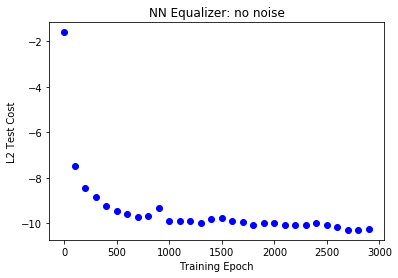

In [5]:
### CFO Multitap channel ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 3000
batch_size = 1500

print("Net trained on omega loss; without noise in preamble")



#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net2 = CFO_Multitap(preamble_length = 40, batch_size=1500, learning_rate = 0.005)

for epoch in range(epochs):
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]   
    preamble_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost = net2.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_channel_batch)

    if epoch % 100 == 0: 


        (test_cost, test_omega, test_loss_mse, w1, b1, w2, b2, w3, b3, w4, b4) = net2.test_net(
            preamble_test_orig,preamble_test_cfo,omega_test, 
                                              preamble_test_channel)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}, MSE Loss: {}'.format(epoch, train_cost,test_cost, 
                                                                            test_loss_mse))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()




In [6]:
file = open('cfo_estimation_weights.txt','w') 
 
file.write(np.array2string(w1,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(b1,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(w2,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(b2,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(w3,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(b3,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(w4,max_line_width=np.inf, threshold=np.inf)+ '|')
file.write(np.array2string(b4,max_line_width=np.inf, threshold=np.inf)+ '|')

file.close()

# len(np.array2string(b3,max_line_width=np.inf, threshold=np.inf))

In [7]:
with open('cfo_estimation_weights.txt') as f: 
#     w1,b1,w2,b2,w3,b3,w4,b4 = f.readlines()
    data = f.readlines() 
    for line in data:
        fields = line.split('|')

print(len(data))
# print(data)
# print(z)


457


True CFO Rate:  [0.0042768]
Estimate CFO Rate:  [-0.00221412]


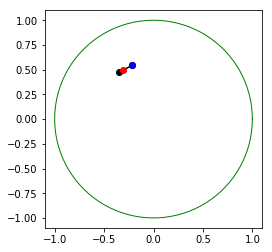

In [8]:

k=90
test_omega = np.array(test_omega)
print("True CFO Rate: ",omega_test[k])
print("Estimate CFO Rate: ",test_omega[k])

preamble_length=40


preamble_cfo_complex = np.vectorize(complex)(preamble_test_cfo[k,:,0], preamble_test_cfo[k,:,1])
preamble_cfo_complex=preamble_cfo_complex.reshape((preamble_length,1))
# print(preamble_cfo_complex.shape)

# build the rotation matrix
incremented_omega = np.zeros((preamble_length,1))
for i in range(preamble_length):
    incremented_omega[i]=-test_omega[k]*i

rotation_complex = np.exp(0.0+1j*incremented_omega)
# print(rotation_complex.shape)

# preamble_rotated_complex = np.multiply(preamble_cfo_complex,rotation_complex)
preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)
# print(preamble_rotated_complex.shape)

preamble_rotated = np.stack([np.real(preamble_rotated_complex[:,:]), 
                             np.imag(preamble_rotated_complex[:,:])], axis=1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')


m=39
for j in range(m,m+1):
    x1, x2 = preamble_test_channel[k,j,0], preamble_rotated[j,0]
    y1, y2 = preamble_test_channel[k,j,1], preamble_rotated[j,1]
    plt.plot([x1,x2],[y1,y2],'ko-')
    plt.plot(x1,y1,'bo')
    
    plt.plot(preamble_test_cfo[k,j,0], preamble_test_cfo[k,j,1],'ro')

    
# plt.plot(x1,y1,'bo')
plt.show()

Net trained on omega loss; with noise in preamble
Epoch 0, Train Cost 3.853333691949956e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 100, Train Cost 3.3776268537621945e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 200, Train Cost 3.6157645808998495e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 300, Train Cost 3.7929257814539596e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 400, Train Cost 3.5380173358134925e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 500, Train Cost 3.212425872334279e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 600, Train Cost 3.178489350830205e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 700, Train Cost 3.2095740607474e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.0233005285263062
Epoch 800, Train Cost 2.9562341296696104e-05, Test Cost: 0.19642874598503113, MSE Loss: 1.023300528526

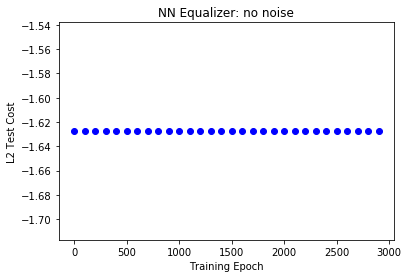

In [9]:
### CFO Multitap channel ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 3000
batch_size = 1500

print("Net trained on omega loss; with noise in preamble")



#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net4 = CFO_Multitap_Noise(preamble_length = 40, batch_size=1500, learning_rate = 0.005)

for epoch in range(epochs):
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_noisy[current_start:(current_start+batch_size),:,:]   
    preamble_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost = net2.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_channel_batch)

    if epoch % 100 == 0: 


        test_cost, test_omega, test_loss_mse = net4.test_net(preamble_test_orig,preamble_test_noisy,omega_test, 
                                              preamble_test_channel)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}, MSE Loss: {}'.format(epoch, train_cost,test_cost, 
                                                                            test_loss_mse))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


True CFO Rate:  [0.0042768]
Estimate CFO Rate:  [0.3468514]


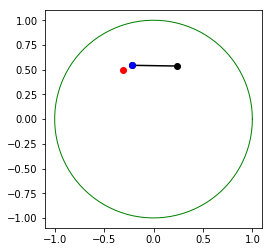

In [10]:
test_omega = np.array(test_omega)
print("True CFO Rate: ",omega_test[k])
print("Estimate CFO Rate: ",test_omega[k])

preamble_length=40


preamble_cfo_complex = np.vectorize(complex)(preamble_test_cfo[k,:,0], preamble_test_cfo[k,:,1])
preamble_cfo_complex=preamble_cfo_complex.reshape((preamble_length,1))
# print(preamble_cfo_complex.shape)

# build the rotation matrix
incremented_omega = np.zeros((preamble_length,1))
for i in range(preamble_length):
    incremented_omega[i]=-test_omega[k]*i

rotation_complex = np.exp(0.0+1j*incremented_omega)
# print(rotation_complex.shape)

# preamble_rotated_complex = np.multiply(preamble_cfo_complex,rotation_complex)
preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)
# print(preamble_rotated_complex.shape)

preamble_rotated = np.stack([np.real(preamble_rotated_complex[:,:]), 
                             np.imag(preamble_rotated_complex[:,:])], axis=1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')


m=39
for j in range(m,m+1):
    x1, x2 = preamble_test_channel[k,j,0], preamble_rotated[j,0]
    y1, y2 = preamble_test_channel[k,j,1], preamble_rotated[j,1]
    plt.plot([x1,x2],[y1,y2],'ko-')
    plt.plot(x1,y1,'bo')
    
    plt.plot(preamble_test_cfo[k,j,0], preamble_test_cfo[k,j,1],'ro')

    
# plt.plot(x1,y1,'bo')
plt.show()

In [11]:
# weights_1_np = np.array(weights_1)
# weights_2_np = np.array(weights_2)
# weights_3_np = np.array(weights_3)
# weights_4_np = np.array(weights_4)

# print(weights_1_np)

In [12]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Multitap is a net that, given a known preamble, will take in the convolved preamble and estimate the CFO.
'''

class CFO_Multitap2():
    def __init__(self, preamble_length = 40, batch_size = 150, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_channel = tf.placeholder(tf.float32, [None, self.preamble_length,2])
        self.omega_original = tf.placeholder(tf.float32, [None, 1])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)
        
        w1_init = tf.constant_initializer(w1)
        w2_init = tf.constant_initializer(w2)
        w3_init = tf.constant_initializer(w3)
        w4_init = tf.constant_initializer(w4)
        b1_init = tf.constant_initializer(b1)
        b2_init = tf.constant_initializer(b2)
        b3_init = tf.constant_initializer(b3)
        b4_init = tf.constant_initializer(b4)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True, kernel_initializer= w1_init,
            bias_initializer=b1_init)
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True, kernel_initializer= w2_init, bias_initializer=b2_init)
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, tf.nn.tanh, use_bias=True, kernel_initializer= w3_init, bias_initializer=b3_init)
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, tf.identity, use_bias=True, kernel_initializer= w4_init, bias_initializer=b4_init)

        self.est_omega = cfo_layer_4
        
        self.mse_omega_loss = tf.losses.mean_squared_error(self.est_omega, self.omega_original)
        ###############
        # CFO Correction on the convolved data
        ###############

        preamble_cfo_complex = tf.complex(self.preamble_convolved[:,:,0], self.preamble_convolved[:,:,1])
        preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

        preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                                     tf.imag(preamble_rotated_complex[:,:])], axis=2)
        
        self.preamble_cfo_corrected = tf.squeeze(preamble_rotated,-1)
#         self.preamble_cfo_corrected=[]
#         for j in range(self.batch_size):
            
#             preamble_corr = []
#             for k in range(self.preamble_length):
#                 real = (self.preamble_channel[j,k,0]*tf.cos(self.est_omega[j]*k)
#                                            -self.preamble_channel[j,k,1]*tf.sin(self.est_omega[j]*k))
#                 imag = (self.preamble_channel[j,k,0]*tf.sin(self.est_omega[j]*k)
#                                           +self.preamble_channel[j,k,1]*tf.cos(self.est_omega[j]*k))
#                 preamble_corr.append(tf.concat([real,imag], 0))
                
#             self.preamble_cfo_corrected.append(preamble_corr)
    
    
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.preamble_channel, self.preamble_cfo_corrected)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_omega, test_est, test_omega_loss = self.sess.run([self.surr,self.est_omega, self.preamble_cfo_corrected, self.mse_omega_loss],
                                                        feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return test_cost,test_omega, test_omega_loss
    
            
    def train_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost, train_omega_loss = self.sess.run([self.update_op, self.surr, self.mse_omega_loss], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return train_cost, train_omega_loss
    
    
    def vis_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Visualize net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            Corrected data
        """

        test_cost, test_omega, test_est, test_omega_loss = self.sess.run([self.surr,self.est_omega, self.preamble_cfo_corrected, self.mse_omega_loss],
                                                        feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        
        return test_est, test_omega
    


Epoch 0, Train Cost 0.00858329888433218, Test Cost: 0.20696187019348145
3.3696753e-05
Epoch 100, Train Cost 0.0066412463784217834, Test Cost: 0.006548101082444191
2.6032976e-05
Epoch 200, Train Cost 0.005586044397205114, Test Cost: 0.005446743685752153
2.2020022e-05
Epoch 300, Train Cost 0.003642656374722719, Test Cost: 0.0039557586424052715
1.4441973e-05
Epoch 400, Train Cost 0.003635833039879799, Test Cost: 0.003305098507553339
1.4336185e-05
Epoch 500, Train Cost 0.003073686035349965, Test Cost: 0.0026510509196668863
1.2133174e-05
Epoch 600, Train Cost 0.002432851120829582, Test Cost: 0.0025795011315494776
9.541532e-06
Epoch 700, Train Cost 0.0032639552373439074, Test Cost: 0.002273200312629342
1.2886687e-05
Epoch 800, Train Cost 0.002544370712712407, Test Cost: 0.002182066673412919
1.0015859e-05
Epoch 900, Train Cost 0.00184595154132694, Test Cost: 0.0023928091395646334
7.3125293e-06
Epoch 1000, Train Cost 0.0018580236937850714, Test Cost: 0.0017882552929222584
7.341128e-06
Epoch 11

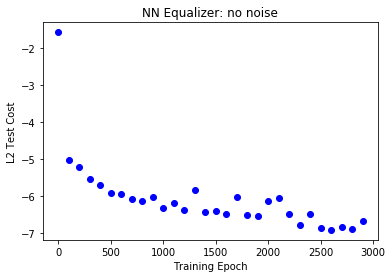

In [13]:
### CFO Preamble Loss ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 3000
batch_size = 1500

#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net3 = CFO_Multitap2(preamble_length = 40, batch_size=1500, learning_rate = 0.001)

for epoch in range(epochs):
    
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]   
    preamble_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost, train_omega_loss = net3.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_channel_batch)

    if epoch % 100 == 0: 
        omega_test_batch = omega_test[current_start:(current_start+batch_size),:]
        preamble_test_orig_batch = preamble_test_orig[current_start:(current_start+batch_size),:,:]
        preamble_test_cfo_batch = preamble_test_cfo[current_start:(current_start+batch_size),:,:]
        preamble_test_channel_batch = preamble_test_channel[current_start:(current_start+batch_size),:,:]

        test_cost, test_omega, test_omega_loss = net3.test_net(preamble_test_orig,preamble_test_cfo,omega_test,
                                              preamble_test_channel)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, train_cost,test_cost))
#         print(test_omega_loss)
        print(train_omega_loss)


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


In [14]:
def make_data(preamble_orig, data_orig, snr, max_omega, channel):
    num_preambles = preamble_orig.shape[0]
    preamble_length = preamble_orig.shape[1]
    data_length = data_orig.shape[1]
    # QPSK
    preamble_cfo = np.zeros((num_preambles,preamble_length,2))
    preamble_channel = np.zeros((num_preambles,preamble_length,2))
    preamble_noisy = np.zeros((num_preambles,preamble_length,2))
    data_cfo = np.zeros((num_preambles,data_length,2))
    data_channel = np.zeros((num_preambles,data_length,2))
    data_noisy = np.zeros((num_preambles,data_length,2))
    
    for pre in range(num_preambles):
        for k in range(2):
            # apply the channel to the preamble
            preamble_channel[pre,:,k] = sig.convolve(preamble_orig[pre,:,k], channel, mode='same')
            data_channel[pre,:,k] = sig.convolve(data_orig[pre,:,k], channel, mode='same')

        # rotate data according to cfo
        preamble_cfo_complex = np.vectorize(complex)(preamble_channel[pre,:,0], preamble_channel[pre,:,1])
        preamble_cfo_complex = preamble_cfo_complex.reshape((preamble_length,1))
        
        data_cfo_complex = np.vectorize(complex)(data_channel[pre,:,0], data_channel[pre,:,1])
        data_cfo_complex = data_cfo_complex.reshape((data_length,1))
        # print(preamble_cfo_complex.shape)

        # build the rotation matrix
        incremented_omega = np.zeros((preamble_length,1))
        for j in range(preamble_length):
            incremented_omega[j]=max_omega*j
            
        incremented_omega_data = np.zeros((data_length,1))
        for j in range(data_length):
            incremented_omega_data[j]=max_omega*j

        rotation_complex = np.exp(0.0+1j*incremented_omega)
        preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)

        preamble_cfo[pre,:,:] = np.squeeze(np.stack([np.real(preamble_rotated_complex[:,:]), 
                                     np.imag(preamble_rotated_complex[:,:])], axis=1),axis=-1)
        
        rotation_complex = np.exp(0.0+1j*incremented_omega_data)
        data_rotated_complex = (data_cfo_complex*rotation_complex)

        data_cfo[pre,:,:] = np.squeeze(np.stack([np.real(data_rotated_complex[:,:]), 
                                     np.imag(data_rotated_complex[:,:])], axis=1),axis=-1)

        
        # add AWG noise to the preamble
        std = np.power(10.0, -snr/20)

        if snr > 0:
            preamble_noisy[pre,:,:] = std * np.random.randn(preamble_length,2)+preamble_cfo[pre,:,:]
            data_noisy[pre,:,:] = std * np.random.randn(data_length,2)+data_cfo[pre,:,:]
        else:
            preamble_noisy[pre,:,:] = preamble_cfo[pre,:,:]
            data_noisy[pre,:,:] = data_cfo[pre,:,:]

    return preamble_cfo, preamble_channel, preamble_noisy, data_noisy


def check_color(preamble_orig,j):
    if preamble_orig[j,0]>0:
        if preamble_orig[j,1]>0:
            color = 'b'
        else:
            color = 'r'
    else:
        if preamble_orig[j,1]>0:
            color = 'g'
        else:
            color = 'y'
    return color


def rotate_data(est_omega, data_noisy):
    # rotate data according to cfo
    data_length = data_noisy.shape[1]
    num_pre = data_noisy.shape[0]
    data_corrected = np.zeros((num_pre, data_length,2))
    
    for pre in range(num_pre):
        data_cfo_complex = np.vectorize(complex)(data_noisy[pre,:,0], data_noisy[pre,:,1])
        data_cfo_complex = data_cfo_complex.reshape((data_length,1))
        # print(preamble_cfo_complex.shape)

        incremented_omega_data = np.zeros((data_length,1))
        for j in range(data_length):
            incremented_omega_data[j]=est_omega[pre]*j

        rotation_complex = np.exp(0.0+1j*-incremented_omega_data)
        data_rotated_complex = (data_cfo_complex*rotation_complex)

        data_corrected[pre,:,:] = np.squeeze(np.stack([np.real(data_rotated_complex[:,:]), 
                                     np.imag(data_rotated_complex[:,:])], axis=1),axis=-1)
        
    return data_corrected

In [105]:
num_preambles = 10

preamble_length = 40
data_length = 200
channel_length = 2
preamble_orig = np.zeros((num_preambles, preamble_length, 2))
data_orig = np.zeros((num_preambles, data_length, 2))

for pre in range(num_preambles):
    preamble_orig[pre,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
    data_orig[pre,:,:] = ((2*np.random.randint(2,size=(data_length,2)))-1)*np.sqrt(2)/2


channel = np.random.uniform(-1,1,channel_length)
channel = channel/(np.linalg.norm(channel))
# channel = [1,0]
print(channel)




[0.36503109 0.93099533]


[0.36503109 0.93099533]


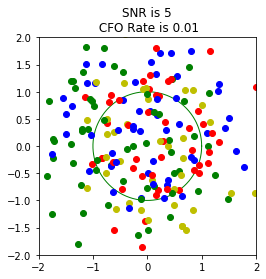

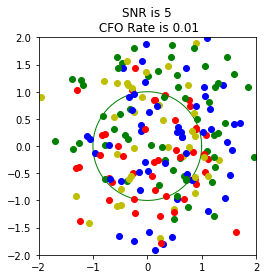

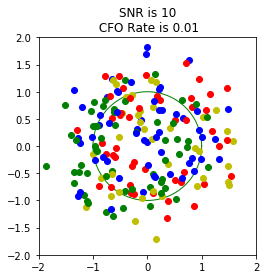

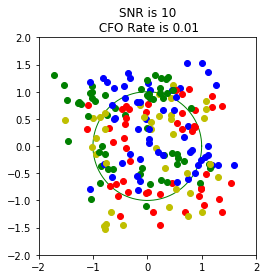

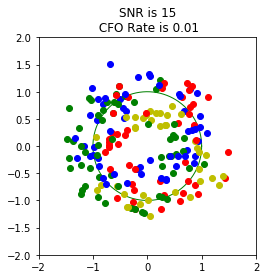

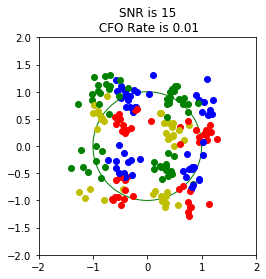

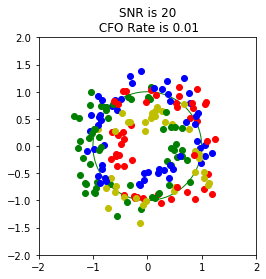

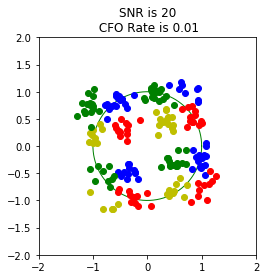

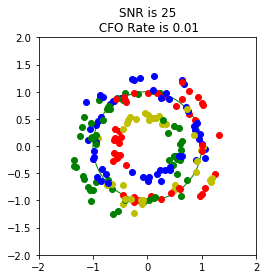

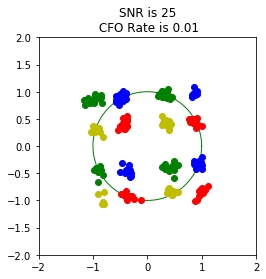

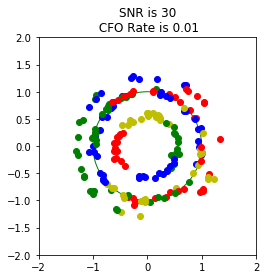

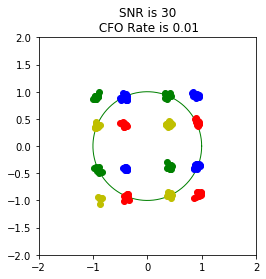

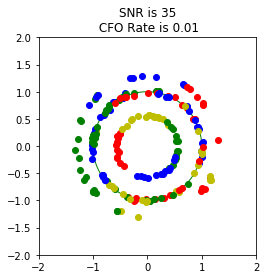

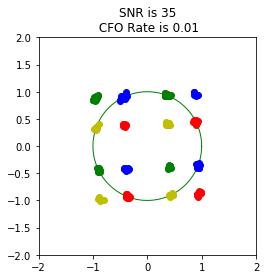

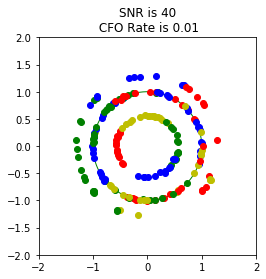

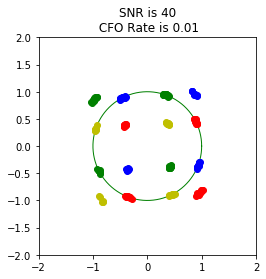

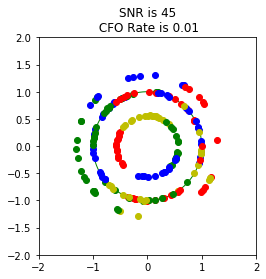

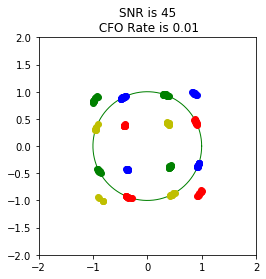

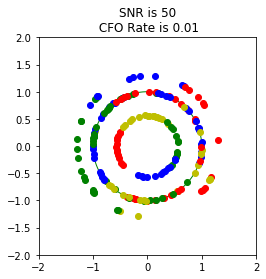

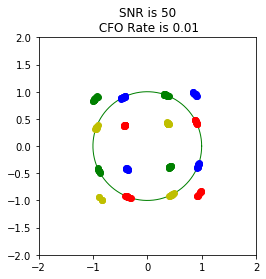

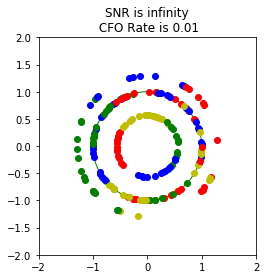

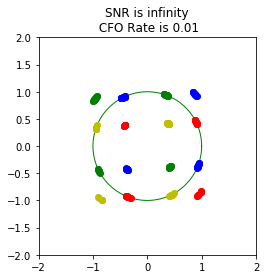

In [109]:
import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import matplotlib.pyplot as plt

import imageio
# import visvis as vv

omega_set = [0, 1/1000, 1/900, 1/800, 1/500, 1/100]
omega_set = [1/100]
snr_set = [5,10, 15, 20, 25, 30,35,40,45 ,50,0]
# snr_set = [0, 50]

print(channel)

prefix = 'multi_tap/'

for k in range(len(omega_set)):
    filenames=[]
    filenames2=[]
    for snr in snr_set:

    #     max_omega = 1/5000
        # max_omega = 0
        max_omega = omega_set[k]

        preamble_cfo, preamble_channel, preamble_noisy, data_noisy = make_data(preamble_orig, data_orig, 
                                                                               snr, max_omega, channel)
        
        corrected_preamble, est_omega = net3.vis_net(preamble_orig,preamble_noisy,
                                          np.ones((num_preambles,1))*max_omega,
                                          preamble_channel)
        
        # rotate the data accroding to CFO est_omega
        corrected_data = rotate_data(est_omega, data_noisy)
        
        
        
        t = np.linspace(0,np.pi*2,100)
        plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
        plt.gca().set_aspect('equal', adjustable='box')
        
        pre = 4

#         for pre in range(1):
        for j in range(1,data_length):
            c = check_color(data_orig[pre,:,:],j)

            plt.plot(data_noisy[pre,j,0], data_noisy[pre,j,1],color=c, marker = 'o')

#                 x1 = preamble_channel[pre,j,0]
#                 y1 = preamble_channel[pre,j,1]
#                 plt.plot(x1,y1,color=c,marker='x',markersize=10)

        plt.axis([-2, 2, -2, 2])
        if snr==0:
            plt.title('SNR is infinity'+'\n CFO Rate is '+str(max_omega))
        else:
            plt.title('SNR is '+str(snr)+'\n CFO Rate is '+str(max_omega))

        file_save = 'cfo_data_vis/'+prefix+'snr_' + str(snr)+ '/cfo_' + str(k)+'.png'
        plt.savefig(file_save)
        # plt.plot(x1,y1,'bo')
        plt.show()
        filenames.append(file_save)
    
        t = np.linspace(0,np.pi*2,100)
        plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
        plt.gca().set_aspect('equal', adjustable='box')
    
#         for pre in range(1):
        for j in range(1,data_length):
            c = check_color(data_orig[pre,:,:],j)

            plt.plot(corrected_data[pre,j,0], corrected_data[pre,j,1],color=c, marker = 'o')

#                 x1 = preamble_channel[pre,j,0]
#                 y1 = preamble_channel[pre,j,1]
#                 plt.plot(x1,y1,color=c,marker='x',markersize=10)

        plt.axis([-2, 2, -2, 2])
        if snr==0:
            plt.title('SNR is infinity'+'\n CFO Rate is '+str(max_omega))
        else:
            plt.title('SNR is '+str(snr)+'\n CFO Rate is '+str(max_omega))

        file_save = 'cfo_data_vis/'+prefix+'corr_snr_' + str(snr)+ '/cfo_' + str(k)+'.png'
        plt.savefig(file_save)
        # plt.plot(x1,y1,'bo')
        plt.show()
        filenames2.append(file_save)

    images = []

    for filename in filenames:
        images.append(imageio.imread(filename))

    gif_name = 'cfo_data_vis/'+prefix+'cfo_'+str(k)+'.gif'
    imageio.mimsave(gif_name, images, format='GIF', duration=1)
    
    images = []

    for filename in filenames2:
        images.append(imageio.imread(filename))

    gif_name = 'cfo_data_vis/'+prefix+'corr_cfo_'+str(k)+'.gif'
    imageio.mimsave(gif_name, images, format='GIF', duration=1)





In [17]:
print(corrected_preamble.shape)

(10, 40, 2)
